# Import

In [40]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

# Import necessary libraries
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

import openml
import tensorflow as tf
import gpflow
from gpflow.kernels import Kernel
from gpflow.utilities import positive

In [4]:
mnist = loadmat("C:\\Users\\31040\\Documents\\VSCode\\intro-numerical-methods\\hw\\mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]

# # Reshape MNIST data
# mnist_data = mnist_data.reshape(mnist_data.shape[0], 28, 28)

# Convert mnist_label to int
mnist_label = mnist_label.astype(int)

print(mnist_data.shape)

(70000, 784)


In [5]:
# Count the number of each digit
count = [0] * 10
for i in range(len(mnist_label)):
    count[mnist_label[i]] += 1
print(count)

[6903, 7877, 6990, 7141, 6824, 6313, 6876, 7293, 6825, 6958]


In [6]:
# Select MNIST 0 and 1
mnist_0 = mnist_data[mnist_label == 0][0:500]
mnist_1 = mnist_data[mnist_label == 1][0:500]

In [7]:
print(mnist_data[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  51 159 253 159  50   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  48 238 252 252 252 237   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  54 227 253 252 239 233 252  57   6   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202  84 252
 253 122   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 163 252 252 252 253 252 252  96 189 253 167   

0


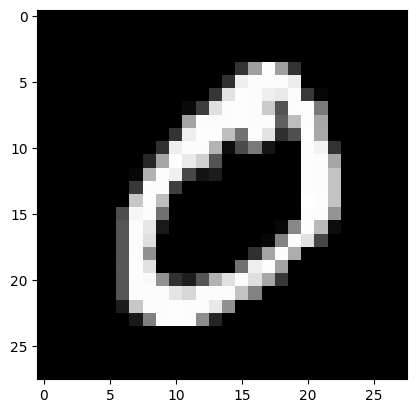

In [8]:
# Show the first image
first_image = mnist_data[0]

print(mnist_label[0])
first_image = np.array(first_image, dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

# Iris Example

In [9]:
# Load the iris dataset
iris = load_iris()
X = iris.data[:, :2]  # Using only the first two features for visualization
y = iris.target

In [10]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=50)

In [11]:
# Standardize the features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

In [12]:
# Define the kernel
kernel = 1.0 * RBF(length_scale=1.0)  # RBF kernel with default parameters

In [13]:
# Create the Gaussian process classifier
gp = GaussianProcessClassifier(kernel=kernel)

# Fit the model to the training data
gp.fit(X_train_standardized, y_train)

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))

In [14]:
# Make predictions on the test data
y_pred = gp.predict(X_test_standardized)

In [15]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.7666666666666667


In [16]:
# Create a mesh grid for visualization
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

In [17]:
# Predict on the mesh grid
X_grid = np.c_[xx.ravel(), yy.ravel()]
X_grid_standardized = scaler.transform(X_grid)
y_pred_grid = gp.predict(X_grid_standardized)
y_pred_grid = y_pred_grid.reshape(xx.shape)

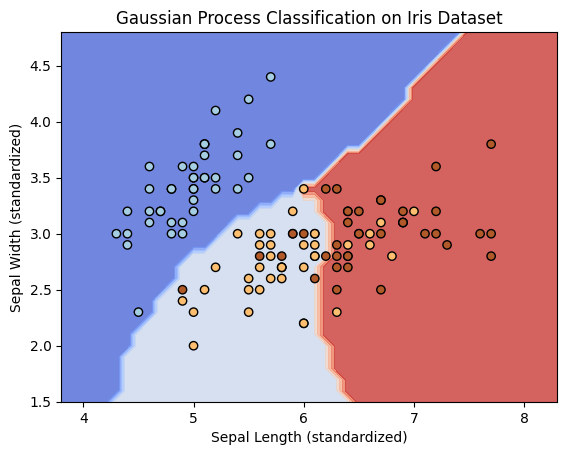

In [18]:
# Plot the mesh grid visualization
plt.contourf(xx, yy, y_pred_grid, cmap='coolwarm', alpha=0.8)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
            edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal Length (standardized)')
plt.ylabel('Sepal Width (standardized)')
plt.title('Gaussian Process Classification on Iris Dataset')
plt.show()

# Invariant Convolution

In [19]:
def invariant_convolutional(input, patch_size):
    # Get the dimensions of the input
    input_shape = input.shape
    input_height = input_shape[0]
    input_width = input_shape[1]
    # input_channels = input_shape[2]

    # Get the dimensions of the patch
    patch_height = patch_size[0]
    patch_width = patch_size[1]

    # Initialize the output feature map
    output = np.zeros((input_height - patch_height + 1, input_width - patch_width + 1))

    # Perform the invariant convolution operation
    for i in range(input_height - patch_height + 1):
        for j in range(input_width - patch_width + 1):
            patch = input[i:i+patch_height, j:j+patch_width, :]
            output[i, j] = np.sum(patch)

    return output

(26, 26)


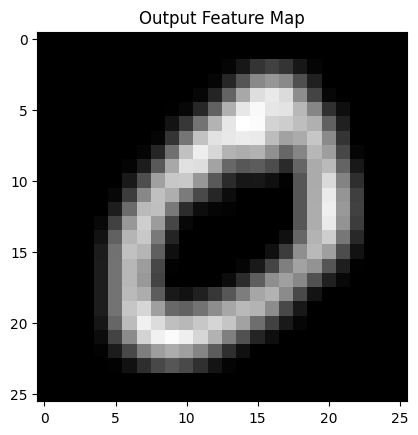

In [20]:
# Try on mnist_data
patch_size = (3, 3)
output = invariant_convolutional(mnist_data[0].reshape(28, 28, 1), patch_size)
print(output.shape)

# Plot the output feature map
plt.imshow(output, cmap='gray')
plt.title('Output Feature Map')
plt.show()

# Classification

In [21]:
X = np.vstack((mnist_0, mnist_1))
y = [0] * len(mnist_0) + [1] * len(mnist_1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=50)

In [22]:
# Standardize the features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

In [23]:
# Define the kernel
kernel = 1.0 * RBF(length_scale=1.0)  # RBF kernel with default parameters

In [24]:
# Create the Gaussian process classifier
gp = GaussianProcessClassifier(kernel=kernel)

# Fit the model to the training data
gp.fit(X_train_standardized, y_train)

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))

In [25]:
# Make predictions on the test data
y_pred = gp.predict(X_test_standardized)

In [26]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.995


# Convolutional Classification GP on MNIST

In [27]:
# Perform invariant convolution on the selected samples
patch_size = (5, 5)
X_train_conv = np.array([invariant_convolutional(sample.reshape(28, 28, 1), patch_size).flatten() for sample in X_train])
X_test_conv = np.array([invariant_convolutional(sample.reshape(28, 28, 1), patch_size).flatten() for sample in X_test])

print(X_train_conv.shape)

# Standardize the features
scaler = StandardScaler()
X_train_conv_standardized = scaler.fit_transform(X_train_conv)
X_test_conv_standardized = scaler.transform(X_test_conv)

# Define the kernel
kernel = 1.0 * RBF(length_scale=1.0)  # RBF kernel with default parameters

(800, 576)


In [28]:
# Create the Gaussian process classifier
gp = GaussianProcessClassifier(kernel=kernel)

# Fit the model to the training data
gp.fit(X_train_conv_standardized, y_train)

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))

In [29]:
# Make predictions on the test data
y_pred = gp.predict(X_test_conv_standardized)

In [30]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.995


# Weighted Convolution

In [31]:
def mean_reference_patch(images, image_size, patch_size):
    # Get the dimensions of the images
    num_images = images.shape[0]
    image_height, image_width = image_size

    # Get the dimensions of the patch
    patch_height = patch_size[0]
    patch_width = patch_size[1]

    # Initialize the reference patch
    reference_patch = np.zeros((patch_height, patch_width))

    # Compute the mean of the patches
    for image in images:
        # Reshape the image
        image = image.reshape(image_height, image_width)
        for j in range(image_height - patch_height + 1):
            for k in range(image_width - patch_width + 1):
                patch = image[j:j+patch_height, k:k+patch_width]
                reference_patch += patch

    reference_patch /= (num_images * (image_height - patch_height + 1) * (image_width - patch_width + 1))

    return reference_patch

In [32]:
def rbf_convolution(input, patch_size, reference_patch, sigma=1.0):

    # Get the dimensions of the input
    input_shape = input.shape
    input_height = input_shape[0]
    input_width = input_shape[1]

    # Get the dimensions of the patch
    patch_height = patch_size[0]
    patch_width = patch_size[1]

    # Initialize the output feature map
    output = np.zeros((input_height - patch_height + 1, input_width - patch_width + 1))

    # Perform the RBF convolution operation
    for i in range(input_height - patch_height + 1):
        for j in range(input_width - patch_width + 1):
            # Extract the patch
            patch = input[i:i+patch_height, j:j+patch_width, :]
            
            # Compute the RBF similarity
            rbf_sum = 0
            diff = patch[:, :] - reference_patch
            squared_norm = np.sum(diff**2)
            rbf_sum += np.exp(-squared_norm / (2 * sigma**2))

            # Store the result in the output
            output[i, j] = rbf_sum

    return output

In [33]:
# Compute the mean reference patch
reference_patch = mean_reference_patch(X_train, (28, 28), (5, 5))

In [34]:
print(reference_patch)

[[43.62212023 43.83149957 43.83495226 43.83753472 43.83751519]
 [43.99389757 44.20327691 44.2067296  44.20931207 44.20929253]
 [44.00374132 44.21312066 44.21657335 44.21915582 44.21913628]
 [44.00374132 44.21312066 44.21657335 44.21915582 44.21913628]
 [43.96826389 44.17764323 44.18109592 44.18367839 44.18365885]]


In [35]:
# Test the rbf_convolution function
patch_size = (5, 5)
sigma = 1.0

X_train_wei_conv = np.array([rbf_convolution(sample.reshape(28, 28, 1), patch_size, reference_patch, sigma=1.0).flatten() for sample in X_train])
X_test_wei_conv = np.array([rbf_convolution(sample.reshape(28, 28, 1), patch_size, reference_patch, sigma=1.0).flatten() for sample in X_test])

# Standardize the features
scaler = StandardScaler()
X_train_wei_conv_standardized = scaler.fit_transform(X_train_wei_conv)
X_test_wei_conv_standardized = scaler.transform(X_test_wei_conv)

# Define the kernel
kernel = 1.0 * RBF(length_scale=1.0)  # RBF kernel with default parameters

In [36]:
# Create the Gaussian process classifier
gp = GaussianProcessClassifier(kernel=kernel)

# Fit the model to the training data
gp.fit(X_train_wei_conv_standardized, y_train)

c:\Users\31040\anaconda3\envs\gp\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))

In [37]:
# Make predictions on the test data
y_pred = gp.predict(X_test_wei_conv_standardized)

In [38]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.47


In [39]:
X_train_wei_conv[100]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.